In [4]:
import os # Configure which GPU 
#import sys
import torch
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

no_preview = True

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

/Users/jokuo/Desktop/ECE257B Final Project/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Num GPUs Available:  0


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from sionna.mimo.precoding import normalize_precoding_power, grid_of_beams_dft
from sionna.rt import visualize 
import math

In [6]:
# --- Find which SINR grid cell a user position falls into ---
def find_cell_index(user_pos, cell_centers, cell_size):
    num_users = user_pos.shape[0]
    cell_zero_pos_x = cell_centers[0, 0, 0]
    cell_zero_pos_y = cell_centers[0, 0, 1]
    del_x = cell_size[0]
    del_y = cell_size[1]

    cell_index_x = []
    cell_index_y = []
    distance = []

    for user in range(num_users):
        user_pos_x = user_pos[user, 0]
        user_pos_y = user_pos[user, 1]

        # Estimate grid index in x and y
        x_index = tf.math.floor(((user_pos_x - cell_zero_pos_x) - del_x / 2) / del_x + 1)
        y_index = tf.math.floor(((user_pos_y - cell_zero_pos_y) - del_y / 2) / del_y + 1)

        cell_index_x.append(int(x_index))
        cell_index_y.append(int(y_index))

        # Get cell center coordinates
        cell_x = cell_centers[int(y_index), int(x_index), 0]
        cell_y = cell_centers[int(y_index), int(x_index), 1]

        # Calculate distance between user and cell center
        dd = tf.math.sqrt((cell_x - user_pos_x) ** 2 + (cell_y - user_pos_y) ** 2)
        distance.append(dd)

    return cell_index_x, cell_index_y, distance

# --- Generate a boolean map of coverage above a power threshold ---
def calculate_cover(coveragemap_list, txpow, threshold, limitarea=True, ar_begin=40, ar_end=200, col_begin=50, col_end=250):
    map = np.zeros_like(coveragemap_list[0], dtype=bool)
    mapp = 10. * np.log10(coveragemap_list[0])
    mapp = (mapp + txpow > threshold)
    map = np.logical_or(map, mapp)

    # Optionally limit to a central area of interest
    if limitarea:
        map = map[ar_begin:ar_end, col_begin:col_end]

    return map

# --- Generate TX positions: one per block, evenly spaced across scene center ---
def generate_tx_positions_dynamic(myscene, num_tx, transmitter_height=49.285, x_factor=0.7, y_factor=0.7):
    scene_x_length = myscene.size[0].numpy() * x_factor
    scene_y_length = myscene.size[1].numpy() * y_factor
    scene_center_x = myscene.center[0].numpy()
    scene_center_y = myscene.center[1].numpy()

    grid_rows = int(np.sqrt(num_tx))
    grid_cols = int(np.ceil(num_tx / grid_rows))
    block_x_size = scene_x_length / grid_cols
    block_y_size = scene_y_length / grid_rows

    tx_positions = np.empty((0, 3), dtype=np.float32)

    for i in range(grid_rows):
        for j in range(grid_cols):
            if len(tx_positions) >= num_tx:
                break
            center_x = scene_center_x - (scene_x_length / 2) + (j + 0.5) * block_x_size
            center_y = scene_center_y - (scene_y_length / 2) + (i + 0.5) * block_y_size
            tx_positions = np.vstack((tx_positions, [center_x, center_y, transmitter_height]))

    return tx_positions

# --- Configure scene with a single TX and RX array ---
def config_scene(scene, num_rows, num_cols, pattern, bs_pwr, tx_pos, look_at=[0, 0, 0]):
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern=pattern,
                                 polarization="V")

    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")

    scene.remove('tx')  # Remove existing TX if any
    scene.add(Transmitter(name='tx',
                          position=tx_pos,
                          look_at=look_at,
                          power_dbm=bs_pwr))
    return scene

# --- Compute coverage map for the current scene configuration ---
def compute_cm(scene):
    cm = scene.coverage_map(
        max_depth=5,
        diffraction=True,
        cm_cell_size=(5., 5.),
        combining_vec=None,
        precoding_vec=None,
        num_samples=int(10e6)
    )
    return cm

# --- Calculate SINR coverage: returns boolean mask and count of blocks above threshold ---
def calculate_sinr_testing(coveragemap_list, threshold):
    mapp = 10. * np.log10(coveragemap_list[0])
    mapp = (mapp > threshold)
    num_lightup_blocks = np.sum(mapp)
    return mapp, num_lightup_blocks

# --- Convert world coordinates to SINR map grid index ---
def return_geoidx2(pslist):
    x0 = -805.583664
    y0 = -688.600626
    del_x = 5
    del_y = 5
    x, y = pslist[:2]
    x_idx = np.round((x - x0) / del_x)
    y_idx = np.round((y - y0) / del_y)
    return int(x_idx), int(y_idx)

# --- Combine two SINR maps (logical OR) and count total covered blocks ---
def compare_sinr_performance(cm_map1, cm_map2):
    overlap_map = np.logical_or(cm_map1, cm_map2)
    num_overlap_blocks = np.sum(overlap_map)
    return overlap_map, num_overlap_blocks

# --- Generate a dense uniform grid of TX positions across center area of the scene ---
def generate_tx_positions(myscene, tx_height=49.285, x_points=100, y_points=100, x_factor=0.7, y_factor=0.7):
    scene_x_length = myscene.size[0].numpy() * x_factor
    scene_y_length = myscene.size[1].numpy() * y_factor
    scene_center_x = myscene.center[0].numpy()
    scene_center_y = myscene.center[1].numpy()
    start_x = scene_center_x - scene_x_length / 2
    start_y = scene_center_y - scene_y_length / 2
    x_array = np.linspace(start_x, start_x + scene_x_length, x_points)
    y_array = np.linspace(start_y, start_y + scene_y_length, y_points)

    tx_positions = np.empty((0, 3), dtype=np.float32)
    for i in range(len(x_array)):
        for j in range(len(y_array)):
            array_temp = np.array([x_array[i], y_array[j], tx_height])
            tx_positions = np.vstack((tx_positions, array_temp))

    return tx_positions, x_array, y_array


Per-antenna power for each N: {1: 10.0, 2: 6.989700043360188, 4: 3.979400086720376, 8: 0.9691001300805642, 16: -2.041199826559248}
Y-grid positions for user probing: [-507.75528564 -477.75528564 -447.75528564 -417.75528564 -387.75528564
 -357.75528564 -327.75528564 -297.75528564 -267.75528564 -237.75528564
 -207.75528564 -177.75528564 -147.75528564 -117.75528564  -87.75528564
  -57.75528564  -27.75528564    2.24471436   32.24471436   62.24471436
   92.24471436  122.24471436  152.24471436  182.24471436  212.24471436
  242.24471436  272.24471436  302.24471436  332.24471436  362.24471436]


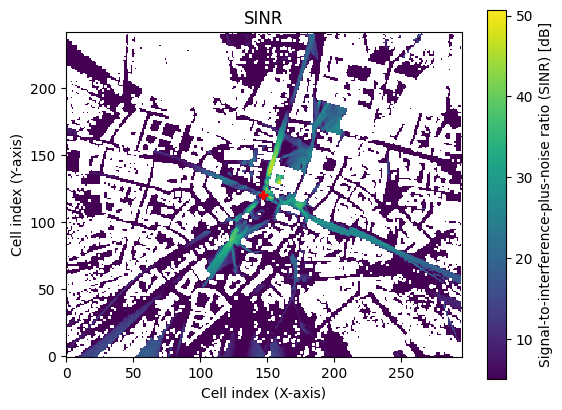

In [7]:
# --- Divide total TX power among multiple antennas (per-antenna power) ---
def divide_power_dBm(P_dBm, N_list):
    """
    For each antenna count N in N_list, calculate the corresponding per-antenna power in dBm
    so that the total TX power remains constant (P_dBm).
    """
    P_linear = 10 ** (P_dBm / 10)  # Convert from dBm to linear (mW)
    power_dict = {N: 10 * np.log10(P_linear / N) for N in N_list}  # Power per antenna in dBm
    return power_dict

# --- Define total TX power and antenna configurations ---
P = 10  # Total power in dBm
N_values = [1, 2, 4, 8, 16]  # Number of antennas to consider
Pw_maps = divide_power_dBm(P, N_values)  # Compute per-antenna power for each case
print("Per-antenna power for each N:", Pw_maps)

# --- Load Munich scene and extract usable parameters ---
sn = load_scene(sionna.rt.scene.munich)

# Define central usable region of scene (70% in both dimensions)
x_factor = 0.7
y_factor = 0.7

# Compute size of usable area
scene_x_length = sn.size[0].numpy() * x_factor
scene_y_length = sn.size[1].numpy() * y_factor

# Get center point of the scene
scene_center_x = sn.center[0].numpy()
scene_center_y = sn.center[1].numpy()

# Calculate start positions of usable area
start_x = scene_center_x - (scene_x_length / 2)
start_y = scene_center_y - (scene_y_length / 2)

# Generate a list of y-axis positions spaced 30 meters apart
y_grid = np.arange(start_y, start_y + scene_y_length + 30, 30)
print("Y-grid positions for user probing:", y_grid)

# --- Configure a 64-antenna (8x8) TX using dipole elements ---
tx_height = 50  # Transmitter height in meters

# Configure scene with dipole pattern, 64 antennas (8x8), using per-antenna power for N=1 (no power division)
scene_1tx_64ant = config_scene(
    scene=sn,
    num_rows=8,
    num_cols=8,
    pattern='dipole',
    bs_pwr=Pw_maps[1],  # Use power corresponding to N=1 (i.e., full 10 dBm)
    tx_pos=[scene_center_x, scene_center_y, tx_height]
)

# --- Compute coverage map (SINR, RSS, etc.) ---
cm_1tx_64ant = compute_cm(scene_1tx_64ant)

# --- Visualize SINR heatmap (only show values ≥ 5 dB) ---
im1 = cm_1tx_64ant.show(metric="sinr", vmin=5)

In [10]:
# --- Set TX height for all generated positions ---
TX_height = 20

# --- Generate TX positions for different TX counts ---
tx_positions = {}
num_tx_list = [2, 4]  # Try 2 and 4 transmitters
for n in num_tx_list:
    # Generate n transmitter positions spaced across the central scene region
    tx_positions[n] = generate_tx_positions_dynamic(
        myscene=sn, 
        num_tx=n, 
        transmitter_height=TX_height
    )

# --- Print the TX positions for the 2-TX case (for inspection/debug) ---
print("TX Positions for 2 TXs:")
print(tx_positions[2])


TX Positions for 2 TXs:
[[-326.05708923  -85.78277588   20.        ]
 [ 190.3561615   -85.78277588   20.        ]]


In [11]:
# --- Load a fresh scene for 2-TX evaluation ---
scene2 = load_scene(sionna.rt.scene.munich)

# --- Basic scene setup ---
scene2.bandwidth = 100e6
scene2.frequency = 2.14e9
scene2.synthetic_array = True  # Enable ideal beam steering

# Threshold to determine SINR-based coverage
sinr_TH = 5

# --- Generate candidate look-at directions (fixed height) ---
look_at_height = 0
look_at_pos, _, _ = generate_tx_positions(
    myscene=sn,
    tx_height=look_at_height,
    x_points=5,
    y_points=5,
    x_factor=0.7,
    y_factor=0.7
)

# Create a dictionary to label each look-at direction
look_at_dict = {i: look_at for i, look_at in enumerate(look_at_pos)}
print("Look-at direction map:")
print(look_at_dict)

# --- Initialize coverage map containers for each transmitter ---
coverage_TX1 = {}  # For TX 1
coverage_TX2 = {}  # For TX 2

# --- Loop over both TX positions (from 2-TX config) ---
for i, pos in enumerate(tx_positions[2]):
    print(f"\nTX{i+1} position:", pos)

    # Sweep all look-at directions
    for j, look_at in enumerate(look_at_pos):
        print("  → Look-at direction:", look_at)

        # Configure scene with TX at 'pos' pointing toward 'look_at'
        scene2 = config_scene(
            scene=scene2,
            num_rows=4,
            num_cols=8,
            pattern='dipole',
            bs_pwr=Pw_maps[2],  # Power split equally for 2 TXs
            tx_pos=pos,
            look_at=look_at
        )

        # Compute SINR coverage and count high-SINR blocks
        cm2 = compute_cm(scene2)
        sinr_cover, number_lightup_blk = calculate_sinr_testing(cm2.sinr, sinr_TH)

        print(f"    Covered blocks: {number_lightup_blk}")

        # Store SINR coverage result for TX1 or TX2
        if i == 0:
            coverage_TX1[j] = sinr_cover
        else:
            coverage_TX2[j] = sinr_cover


Look-at direction map:
{0: array([-584.2637146 , -507.75528564,    0.        ]), 1: array([-584.2637146 , -296.76903076,    0.        ]), 2: array([-584.2637146 ,  -85.78277588,    0.        ]), 3: array([-584.2637146,  125.203479 ,    0.       ]), 4: array([-584.2637146 ,  336.18973389,    0.        ]), 5: array([-326.05708923, -507.75528564,    0.        ]), 6: array([-326.05708923, -296.76903076,    0.        ]), 7: array([-326.05708923,  -85.78277588,    0.        ]), 8: array([-326.05708923,  125.203479  ,    0.        ]), 9: array([-326.05708923,  336.18973389,    0.        ]), 10: array([ -67.85046387, -507.75528564,    0.        ]), 11: array([ -67.85046387, -296.76903076,    0.        ]), 12: array([-67.85046387, -85.78277588,   0.        ]), 13: array([-67.85046387, 125.203479  ,   0.        ]), 14: array([-67.85046387, 336.18973389,   0.        ]), 15: array([ 190.3561615 , -507.75528564,    0.        ]), 16: array([ 190.3561615 , -296.76903076,    0.        ]), 17: array([1

Best location with maximum overlap: (array([-584.2637146,  125.203479 ,    0.       ]), array([448.56278687, 125.203479  ,   0.        ])) with 2438 overlap blocks
96 121


/var/folders/t6/hxv194_11rnb1z4tn9q6s56r0000gn/T/ipykernel_22499/2378147294.py:115: RuntimeWarning: divide by zero encountered in log10
  mapp = 10.*np.log10(coveragemap_list[0])


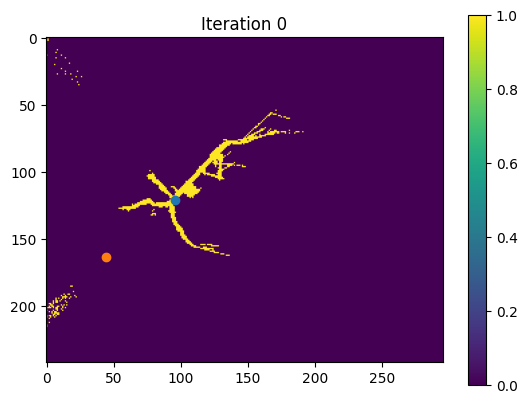

199 121


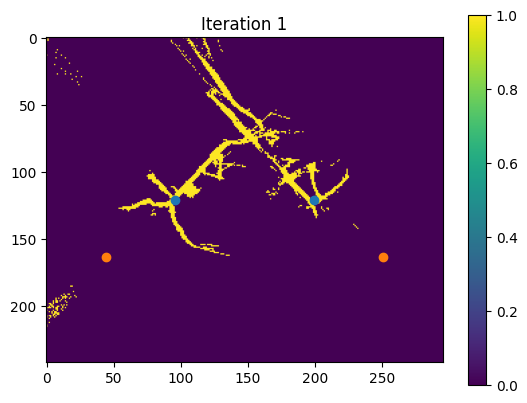

In [8]:
max_overlap = float('-inf')
best_location = (None, None)
optimal_map = 0
for key1, val1 in coverage_TX1.items():
    for key2, val2 in coverage_TX2.items():
        overlap_map, num_overlap_blocks_temp = compare_sinr_performance(val1, val2)
        # print(key1, key2, num_overlap_blocks_temp)
        if num_overlap_blocks_temp > max_overlap:
            max_overlap = num_overlap_blocks_temp
            optimal_map = overlap_map
            best_location = (look_at_dict[key1], look_at_dict[key2])
        
print("Best location with maximum overlap:", best_location, "with", max_overlap, "overlap blocks")

sn2 = load_scene(sionna.rt.scene.munich)

# Scene setup
sn2.bandwidth=100e6
sn2.frequency = 2.14e9
sn2.synthetic_array = False
x = []
y = []
rss_TH = -100
sinr_TH = 5

# Without interference
x_theory = []
y_theory = []
sinr_cover = 0
for i, tx_pos in enumerate(tx_positions[2]):
    plt.figure()
    x_temp,y_temp = return_geoidx2(tx_pos)
    print(x_temp, y_temp)
    x_theory.append(x_temp)
    y_theory.append(y_temp)
    x_look, y_look = return_geoidx2(best_location[i])
    x.append(x_look)
    y.append(y_look)
    
    sn_2tx = config_scene(sn2, 4, 8, 'dipole', Pw_maps[2], tx_pos, best_location[i])
    cm_2tx = compute_cm(sn_2tx)
    
    sinr_cover_temp, number_lightup_blk = calculate_sinr_testing(cm_2tx.sinr, sinr_TH)
    sinr_cover, num_overlap_blocks_temp = compare_sinr_performance(sinr_cover, sinr_cover_temp)

    plt.scatter(x_theory, y_theory)
    plt.scatter(x, y)
    plt.imshow(sinr_cover, cmap='viridis')
    plt.title(f"Iteration {i}")
    plt.colorbar()  # Optional: add a colorbar to indicate SINR scale
    plt.show()

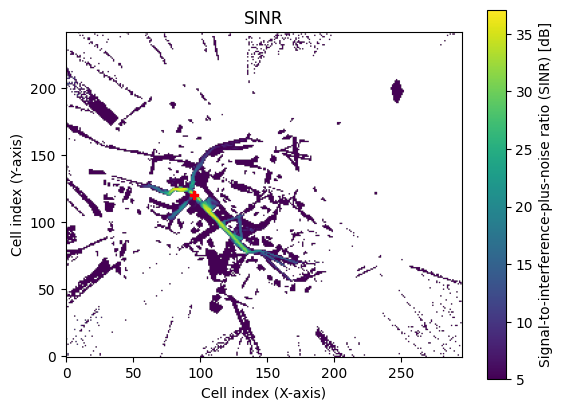

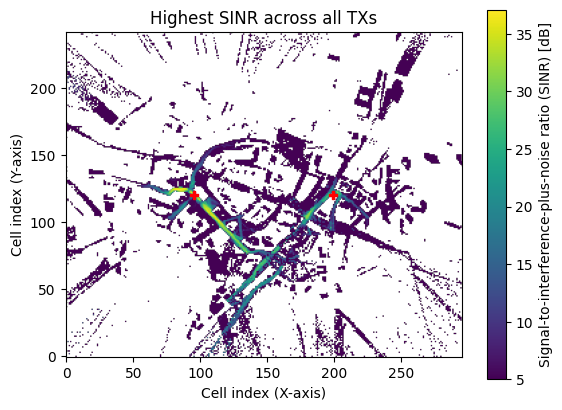

In [12]:
def config_scene_MISO(scene, num_rows, num_cols, pattern, bs_pwr, tx_pos, iter_num, look_at = [0,0,0]):
    # scene = load_scene(sionna.rt.scene.munich)
    
    scene.bandwidth=100e6
    scene.frequency = 2.14e9
    scene.synthetic_array = True
    
    # Configure planar arrays for all TX and RX
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern=pattern,
                                 polarization="V")

    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 vertical_spacing=0.5,
                                 horizontal_spacing=0.5,
                                 pattern="iso",
                                 polarization="V")
    
    scene.add(Transmitter(name=f'tx{iter_num}',
                          position= tx_pos,
                          look_at= look_at,
                          power_dbm = bs_pwr))
    return scene


scene2 = load_scene(sionna.rt.scene.munich)

sinr_TH = 5

# actual coverage
for i, tx_pos in enumerate(tx_positions[2]):
    sn_2tx_real = config_scene_MISO(scene2, 4, 8, 'dipole', Pw_maps[2], tx_pos, i, best_location[i])
    cm_2tx_real = compute_cm(sn_2tx_real)
    cm_2tx_real.show(metric = "sinr",vmin=5)

# im = cm_2tx_real.show(metric = "sinr")

Maximum SNR in the map:  37.091415
Blocks above the threshold:  2309


/var/folders/t6/hxv194_11rnb1z4tn9q6s56r0000gn/T/ipykernel_22499/692538445.py:8: RuntimeWarning: divide by zero encountered in log10
  snr_db = 10 * np.log10(snr_linear)


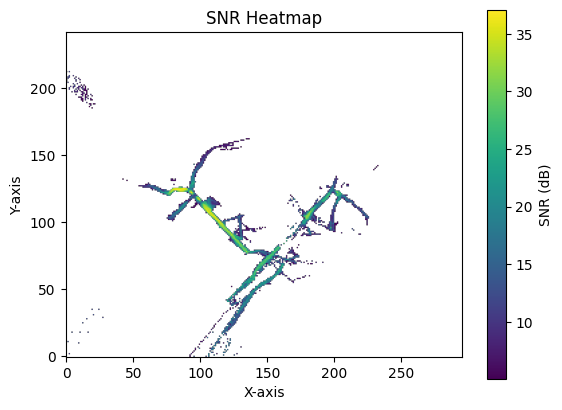

In [13]:
def my_snr(rss_map, scene):
    sum_rss = np.sum(rss_map, axis=0)
    # Get thermal noise power
    noise = scene.thermal_noise_power
    # Compute linear SNR
    snr_linear = sum_rss / noise
    # convert snr from linear to dB
    snr_db = 10 * np.log10(snr_linear)
    snr_db[snr_db < 5] = np.nan
    max_snr = np.nanmax(snr_db)
    blocks_above_threshold = np.sum(~np.isnan(snr_db))
    return snr_db, max_snr, blocks_above_threshold
    
def plot_snr_map(cmapp):
    # Create a heatmap
    # cmappp = cmapp[0]
    plt.imshow(cmapp, cmap='viridis',  origin='lower')
    plt.colorbar(label="SNR (dB)")
    plt.title("SNR Heatmap")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()
    
snr, max_snr, blocks = my_snr(cm_2tx_real.rss, scene2)
print("Maximum SNR in the map: ", max_snr)
print("Blocks above the threshold: ", blocks)
plot_snr_map(snr)

In [12]:
scene2.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [14]:
Pw_maps[2]

6.989700043360188

In [15]:
Pw_maps

{1: 10.0,
 2: 6.989700043360188,
 4: 3.979400086720376,
 8: 0.9691001300805642,
 16: -2.041199826559248}